# EMPLOYEE ATTRITION FINDER

# [PROJECT](https://www.kaggle.com/c/summeranalytics2020/) based on [6 week course](http://www.caciitg.in/sa2020/course), SummerAnalytics2020 held by [Consulting and Analytics Club (IIT Guwahati)](https://caciitg.in)

# PROJECT was basically A Kaggle Competition

In [1]:
#import basic libraries for visualisation and computation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#import all models to be used
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

#import metric specified in competition
from sklearn.metrics import roc_auc_score

#import some basic preprocessing methods
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler

#import important splitting methods
from sklearn.model_selection import train_test_split, cross_val_score

#feature importance calculator
from sklearn.feature_selection import chi2

In [2]:
#download the traininf and testing data
train_data_orig = pd.read_csv('train.csv', index_col='Id')
test_data_orig = pd.read_csv('test.csv', index_col='Id')

In [3]:
#set to show all columns(default=15)
pd.set_option('max_columns', None)

In [4]:
#check how your data looks
train_data_orig.head(8)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,30,0,Non-Travel,Research & Development,2,3,Medical,571,3,Female,3,Laboratory Technician,4,Single,2564,0,No,14,3,0,12,2,11,7,6,7,4,1
2,36,0,Travel_Rarely,Research & Development,12,4,Life Sciences,1614,3,Female,3,Manufacturing Director,3,Married,4663,9,Yes,12,3,2,7,2,3,2,1,1,2,1
3,55,1,Travel_Rarely,Sales,2,1,Medical,842,3,Male,3,Sales Executive,4,Single,5160,4,No,16,3,0,12,3,9,7,7,3,5,1
4,39,0,Travel_Rarely,Research & Development,24,1,Life Sciences,2014,1,Male,3,Research Scientist,4,Single,4108,7,No,13,3,0,18,2,7,7,1,7,4,1
5,37,0,Travel_Rarely,Research & Development,3,3,Other,689,3,Male,3,Manufacturing Director,3,Married,9434,1,No,15,3,1,10,2,10,7,7,8,1,1
6,31,0,Travel_Rarely,Sales,7,4,Life Sciences,941,2,Male,2,Sales Representative,3,Married,2329,3,No,15,3,0,13,2,7,7,5,2,2,1
7,32,1,Travel_Rarely,Research & Development,1,3,Life Sciences,331,4,Male,2,Laboratory Technician,3,Single,3730,0,Yes,14,3,0,4,2,3,2,1,2,1,1
8,33,0,Travel_Rarely,Research & Development,4,4,Medical,1502,1,Female,2,Laboratory Technician,2,Married,3838,8,No,11,3,0,8,5,5,4,0,2,5,1


In [5]:
#check for null values
train_data_orig.isnull().sum().sum()

0

Training Data looks pretty clean

In [6]:
#split the data into predictor and prediction
#store in separate variable everytime to avoid some invisible errors
X_orig = train_data_orig.drop(['Attrition'],axis=1)
y = train_data_orig.Attrition

In [7]:
# There are columns with datatype object
# Convert it into integer for better ML implementation
# LabelEncoder used for same purpose (OneHotEncoder can also be used)

X = X_orig.copy() # keep your original data unaltered  
X_test = test_data_orig.copy()
label_encoder = LabelEncoder()
columns = X.columns
# List of Object columns
object_cols = [col for col in X.columns if X[col].dtype == "object"] 

# Always do Same preprocessing for Train and Test data
for col in object_cols:
    X[col] = label_encoder.fit_transform(X[col])
    X_test[col] = label_encoder.fit_transform(X_test[col])

In [9]:
# Check how it looks
X.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,30,0,1,2,3,3,571,3,0,3,2,4,2,2564,0,0,14,3,0,12,2,11,7,6,7,4,1
2,36,2,1,12,4,1,1614,3,0,3,4,3,1,4663,9,1,12,3,2,7,2,3,2,1,1,2,1
3,55,2,2,2,1,3,842,3,1,3,7,4,2,5160,4,0,16,3,0,12,3,9,7,7,3,5,1
4,39,2,1,24,1,1,2014,1,1,3,6,4,2,4108,7,0,13,3,0,18,2,7,7,1,7,4,1
5,37,2,1,3,3,4,689,3,1,3,4,3,1,9434,1,0,15,3,1,10,2,10,7,7,8,1,1


In [10]:
X_test.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,28,2,1,9,3,3,377,4,1,3,6,4,1,2070,1,0,23,4,1,5,3,5,2,0,4,5,1
2,31,2,2,6,4,3,653,1,1,4,7,4,0,5460,4,0,22,4,2,13,4,7,7,5,7,3,1
3,37,2,1,6,3,3,474,3,1,4,6,1,0,5974,4,1,13,3,2,13,2,7,7,6,7,4,1
4,42,2,1,1,2,1,827,4,0,2,4,4,1,6062,9,1,13,3,1,8,4,4,3,0,2,5,1
5,45,0,1,4,2,1,972,3,1,3,2,2,1,4447,1,0,12,3,0,9,5,9,7,0,8,2,1


In [11]:
# check for columns with less or very large no. of unique entries
for col in X.columns:
    print(col,X[col].nunique())

Age 43
BusinessTravel 3
Department 3
DistanceFromHome 29
Education 5
EducationField 6
EmployeeNumber 1000
EnvironmentSatisfaction 4
Gender 2
JobInvolvement 4
JobRole 9
JobSatisfaction 4
MaritalStatus 3
MonthlyIncome 941
NumCompaniesWorked 10
OverTime 2
PercentSalaryHike 15
PerformanceRating 2
StockOptionLevel 4
TotalWorkingYears 39
TrainingTimesLastYear 7
YearsAtCompany 36
YearsInCurrentRole 19
YearsSinceLastPromotion 16
YearsWithCurrManager 18
CommunicationSkill 5
Behaviour 1


In [12]:
# 'Behaviour' column is of no use
X.drop(['Behaviour'],axis=1,inplace=True)
X_test.drop(['Behaviour'],axis=1,inplace=True)

In [13]:
# Shape of data
print(X.shape,X_test.shape)

(1628, 26) (470, 26)


## Checking score with very rough models
## Without further Preprocessing

In [14]:
def crossvalidationscore(model, X, y, cv):
    '''
    A function to return cross validation scores to prevent overfitting with one part of data
    This will take every data at least once in every model as in training set or validation set 
    '''
    scorelist = cross_val_score(model, X, y, cv = cv, scoring = 'roc_auc')
    meanscore = scorelist.mean()
    return {'scorelist':scorelist, 'meanscore':meanscore}

In [15]:
# TrainTestSplit for checking scores 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8,random_state=1)

#  Starting with basic models

# Logistic Regression

In [16]:
LR = LogisticRegression(solver='lbfgs')
print(crossvalidationscore(LR, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.85090265, 0.8476614 , 0.84573927, 0.85232787, 0.84159842]), 'meanscore': 0.847645923405355}


# Naive Bayes

In [17]:
nb = GaussianNB()
print(crossvalidationscore(nb, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.78664305, 0.78630385, 0.7850978 , 0.77972399, 0.76747801]), 'meanscore': 0.7810493401747689}


# XGBoost

In [18]:
xgb = XGBClassifier()
print(crossvalidationscore(xgb, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.96932122, 0.96069046, 0.97199714, 0.97554595, 0.97600091]), 'meanscore': 0.97071113599776}


# NeuralNetwork

In [19]:
nn = MLPClassifier(max_iter=2000)
print(crossvalidationscore(nn, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.97817812, 0.97761278, 0.97795198, 0.98745071, 0.94661814]), 'meanscore': 0.9735623473374575}


# SVM

In [20]:
from sklearn.svm import SVC
svc = SVC(gamma='scale')
print(crossvalidationscore(svc, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.97896959, 0.97252478, 0.97746203, 0.98623749, 0.97543221]), 'meanscore': 0.9781252187303142}


# AdaBoostClassifier

In [21]:
abc = AdaBoostClassifier()
print(crossvalidationscore(abc, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([0.91689594, 0.90577771, 0.92292617, 0.92553837, 0.90764331]), 'meanscore': 0.9157562998817286}


 # RandomForest

In [22]:
rfr = RandomForestClassifier(n_estimators=100)
print(crossvalidationscore(rfr, StandardScaler().fit_transform(X), y, 5))

{'scorelist': array([1., 1., 1., 1., 1.]), 'meanscore': 1.0}


### Three best models are #Randomforest, #SVC, #Neural_network

'roc_auc score' is 1 for RF.   
Looks pretty perfect.   
let's submit our predictions on kaggle and check results.

In [23]:
# Check standard submission format
sample_submission = pd.read_csv('Sample_submission.csv')
sample_submission.head()

,Id,Attrition
0,1,0.742476
1,2,0.347438
2,3,0.938753
3,4,0.456471
4,5,0.363193


## Submitting two best predictions

In [25]:
rfr1 = RandomForestClassifier(n_estimators=100)

## Before final submission always fit on full training data 
rfr1.fit(X, y) 

# Using predict_proba as sample submission contains probability 
pred_rfr1 = rfr1.predict_proba(X_test)[:,1]
output = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_rfr1})
# Saving the submission file
output.to_csv('submission_rfr1.csv', index=False)

In [26]:
# check how your submission looks
submission1 = pd.read_csv('submission_rfr1.csv')
print('length of submission = ',len(submission1))
submission1.head()

length of submission =  470


,Id,attrition
0,1,0.07
1,2,0.06
2,3,0.12
3,4,0.22
4,5,0.06


In [27]:
# Repeat for SVM

svc1 = SVC(gamma='scale')
svc1.fit(X, y)

pred_svc1 = svc1.predict(X_test)
output = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_svc1})
output.to_csv('submission_svc1.csv', index=False)

In [28]:
submission2 = pd.read_csv('submission_svc1.csv')
print('length of submission = ',len(submission2))
submission2.head()

length of submission =  470


,Id,attrition
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


### Kaggle score comes out to be around 0.75 for both submissions
### Definitely there is difference in train and test data

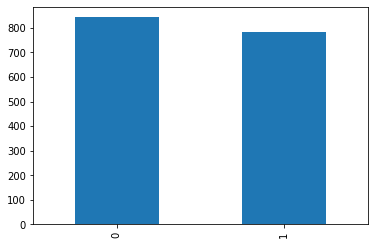

In [29]:
# Plot no of 0's and 1's in training data
y.value_counts().plot.bar()

33 437


(array([399.,  71.]), array([0. , 0.4, 0.8]), <a list of 2 Patch objects>)

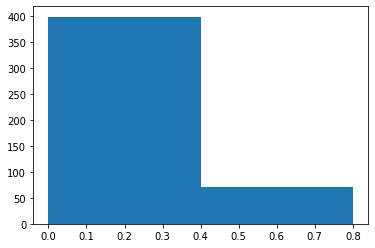

In [30]:
# Check frequency of (more than 0.5)'s and (less than 0.5)'s
print(len(pred_rfr1[pred_rfr1 > 0.5]),len(pred_rfr1[pred_rfr1 <= 0.5]))
plt.hist(pred_rfr1,2)

Although we dont know the predictions
but its clear that there are more 0's than 1's in test data as our score is 75%
This looks like case of 
## imbalanced data

# Upsampling 0's in training data so that we train accordingly

In [31]:
# Concatenating X and y for upsampling of 0's
train_data_std = X.copy()
train_data_std['Attrition'] = y
train_data_std.head()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Attrition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,30,0,1,2,3,3,571,3,0,3,2,4,2,2564,0,0,14,3,0,12,2,11,7,6,7,4,0
2,36,2,1,12,4,1,1614,3,0,3,4,3,1,4663,9,1,12,3,2,7,2,3,2,1,1,2,0
3,55,2,2,2,1,3,842,3,1,3,7,4,2,5160,4,0,16,3,0,12,3,9,7,7,3,5,1
4,39,2,1,24,1,1,2014,1,1,3,6,4,2,4108,7,0,13,3,0,18,2,7,7,1,7,4,0
5,37,2,1,3,3,4,689,3,1,3,4,3,1,9434,1,0,15,3,1,10,2,10,7,7,8,1,0


In [32]:
# Split class into 0's and 1's
X1 = train_data_std[train_data_std.Attrition == 1]
X0 = train_data_std[train_data_std.Attrition == 0]

print(len(X1),len(X0))

785 843


In [33]:
# Upsampling method
from sklearn.utils import resample
X0_os = resample(X0, 
                 replace=True, 
                 n_samples=int(len(X1)*1.6), 
                 random_state=27) #reproducible results

In [35]:
# Conatenate both classes for training FURTHER
X_os = pd.concat([X0_os,X1]) # oversampled X
y_os = X_os.Attrition # oversampled y
X_os.drop(['Attrition'], axis=1, inplace=True)

### Implementing models again

# SVM 

In [36]:
from sklearn.svm import SVC
svc = SVC(gamma='scale')
print(crossvalidationscore(svc, 
                           StandardScaler().fit_transform(X_os), # Using StandardScaler as SVM IS sensitive 
                           y_os, 5))                             # Standardize values to (-1,1)

{'scorelist': array([0.99479325, 0.98921511, 0.99292004, 0.98383536, 0.99309767]), 'meanscore': 0.9907722864481816}


# RandomForest

In [37]:
rfr = RandomForestClassifier(n_estimators=100)
print(crossvalidationscore(rfr, StandardScaler().fit_transform(X_os), y_os, 5))

{'scorelist': array([1., 1., 1., 1., 1.]), 'meanscore': 1.0}


SVM score is improved.  
RandomForest stays looking perfect. 
let's submit new predictions.

In [38]:
rfr2 = RandomForestClassifier(n_estimators=100)

## Before final submission always fit on full training data 
rfr2.fit(X_os, y_os) 

# Using predict_proba as sample submission contains probability 
pred_rfr2 = rfr2.predict_proba(X_test)[:,1]
output1 = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_rfr2})
# Saving the submission file
output1.to_csv('submission_rfr2.csv', index=False)


# Repeat for SVM

svc2 = SVC(gamma='scale')
svc2.fit(X_os, y_os)

pred_svc2 = svc2.predict(X_test)
output2 = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_svc2})
output2.to_csv('submission_svc2.csv', index=False)

#### Kaggle score shows improvement to both around 0.78
### Need to try something else.

# Hyperparameter Tuning

In [39]:
# importing necessary library to check for best combination of parameters
from sklearn.model_selection import GridSearchCV

In [40]:
param = {#'n_estimators':[20,50,80,200,500,1000], 
         #'learning_rate':[0.01,0.05,0.1], 
         #'max_depth': [1,2, 5,7], 
         'C': [0.1, 1, 10], 
         'kernel': ['rbf', 'poly'], 
         'degree': [2,3,4]
        }

grid1 = GridSearchCV(estimator=svc, param_grid=param, scoring='roc_auc', cv=5)
grid1.fit(X, y)
print('best parameters : ', grid1.best_params_)

best parameters :  {'C': 10, 'degree': 2, 'kernel': 'rbf'}


In [41]:
# check scores with updated model
svc3 = SVC(gamma='scale',C=10, kernel='rbf', degree=2)
print(crossvalidationscore(svc3, StandardScaler().fit_transform(X_os), y_os, 5))

{'scorelist': array([1.        , 0.99621895, 1.        , 0.99269165, 1.        ]), 'meanscore': 0.9977821199279315}


In [42]:
param2 = {'n_estimators':[20,50,80,200,500,1000], 
         'learning_rate':[0.01,0.05,0.1], 
         'max_depth': [1,2, 5,7], 
         #'C': [0.1, 1, 10], 
         #'kernel': ['rbf', 'poly'], 
         #'degree': [2,3,4]
        }

grid1 = GridSearchCV(estimator=xgb, param_grid=param2, scoring='roc_auc', cv=5)
grid1.fit(X, y)
print('best parameters', grid1.best_params_, '\nscore : ', grid1.best_score_)

best parameters {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 1000} 
score :  0.9985283265538042


Both validation score shows improvement.   
Let's submit all 3 submissions.  

In [43]:
rfr3 = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=10, max_depth=7)

## Before final submission always fit on full training data 
rfr3.fit(X_os, y_os) 

# Using predict_proba as sample submission contains probability 
pred_rfr3 = rfr3.predict_proba(X_test)[:,1]
output3 = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_rfr3})
# Saving the submission file
output3.to_csv('submission_rfr3.csv', index=False)


# Repeat for SVM

svc3 = SVC(gamma='scale',C=10, kernel='rbf', degree=2)
svc3.fit(X_os, y_os)

pred_svc3 = svc3.predict(X_test)
output4 = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_svc3})
output4.to_csv('submission_svc3.csv', index=False)

# Repeat for XGBClassifier

xgb1 = XGBClassifier(learning_rate=0.05, n_estimators=1000, max_depth=7)
xgb1.fit(X_os, y_os)
pred_xgb1 = xgb1.predict_proba(X_test)[:,1]

output5 = pd.DataFrame({'Id': X_test.index,
                       'attrition': pred_xgb1})
output5.to_csv('submission_xgb1.csv', index=False)

### Score increased to 0.82 , maximum till now
## It looks like training data is different from test data, thus hard to perfectionize model.

In [44]:
# Checking if training data different from test data
# Test for feature with maximum importance(predicted by chi2 method)
col_values = list(X.columns.values)
feature_scores = chi2(X_train, y_train)[0]
for score, fname in sorted(zip(feature_scores, col_values), reverse=True)[:20]:
    print(fname, score)

MonthlyIncome 252388.19860097504
EmployeeNumber 813.8189890644849
TotalWorkingYears 492.1531052690799
YearsAtCompany 349.9663720451987
YearsInCurrentRole 300.23617315795974
YearsWithCurrManager 209.95477216479355
Age 145.9161857389169
DistanceFromHome 87.64406191650258
OverTime 78.601191211226
StockOptionLevel 33.27651420037152
JobRole 28.204259984666894
MaritalStatus 20.872771857743427
YearsSinceLastPromotion 15.883487898702507
JobSatisfaction 12.63054903565424
TrainingTimesLastYear 11.510823757342585
CommunicationSkill 10.930028991763763
EnvironmentSatisfaction 9.328840520455929
JobInvolvement 7.1240311655036646
Department 3.016771404935743
NumCompaniesWorked 2.9874623201645987


(array([778., 451., 191.,  89.,  42.,  77.]),
 array([ 1009.,  4174.,  7339., 10504., 13669., 16834., 19999.]),
 <a list of 6 Patch objects>)

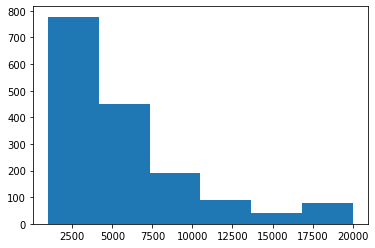

In [45]:
# Plotting MonthlyIncome for training data
plt.hist(X.MonthlyIncome,6)

(array([180., 155.,  52.,  31.,  17.,  35.]),
 array([ 1091.,  4233.,  7375., 10517., 13659., 16801., 19943.]),
 <a list of 6 Patch objects>)

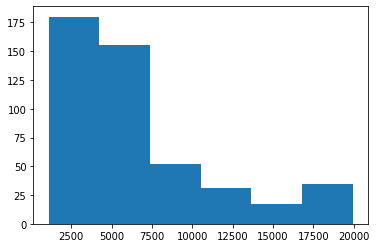

In [46]:
# Plotting MonthlyIncome for testing data
plt.hist(X_test.MonthlyIncome,6)

### Columns with greatest chi2 values looks same for train and test data
# Myconclusion
### possibly data leak in feature of least importance, leading to imperfect results

Additional reason for not so good results:
    1. There are few features that are highly correlated and can be merged.
    2. Better use of data visualisation to find out underlying leak.
    3. Data is duplicated (this I found later).